<a href="https://colab.research.google.com/github/ProfAI/machine-learning-fondamenti/blob/main/Progetto%20Finale%20-%20Cross%20Selling%20di%20Polizze/health_insurance_cross_sell_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsione di opportunità di Cross Sell di assicurazioni

Il cliente è una compagnia di assicurazioni che ha fornito un'assicurazione sanitaria ai suoi clienti, adesso hanno bisogno del tuo aiuto per costruire un modello predittivo in grado di prevedere se gli assicurati dell'anno passato potrebbero essere interessati ad acquistare anche un'assicurazione per il proprio veicolo.

Il dataset è composto dalle seguenti proprietà:
- **id**: id univoco dell'acquirente.
- **Gender**: sesso dell'acquirente.
- **Age**: età dell'acquirente.
- **Driving_License**: 1 se l'utente ha la patente di guida, 0 altrimenti.
- **Region_Code**: codice univoco della regione dell'acquirente.
- **Previously_Insured**: 1 se l'utente ha già un veicolo assicurato, 0 altrimenti.
- **Vehicle_Age**: età del veicolo
- **Vehicle_Damage**: 1 se l'utente ha danneggiato il veicolo in passato, 0 altrimenti.
- **Annual_Premium**: la cifra che l'utente deve pagare come premio durante l'anno.
- **Policy_Sales_Channel**: codice anonimizzato del canale utilizzato per la proposta (es. per email, per telefono, di persona, ecc...)
- **Vintage**: numero di giorni dalla quale l'utente è cliente dell'azienda.
- **Response**: 1 se l'acquirente ha risposto positivametne alla proposta di vendità, 0 altrimenti.

L'obiettivo del modello è prevedere il valore di **Response**.

**Tip**
Fai attenzione alla distribuzione delle classi, dai uno sguardo a [questo approfondimento](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/). In caso di classi sbilanciate puoi provare a:

- Penalizzare la classe più frequente (ricorda l'argomento class_weight)
- Utilizzare [l'oversampling o l'undersampling](https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/).


[LINK AL DATASET (Richiede un'account su Kaggle)](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction)

# RESOURCE LOADING

In [67]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler #standardizzazione

from imblearn.over_sampling import SMOTE
from collections import Counter

#previsione
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, log_loss, classification_report
from sklearn.metrics import recall_score, precision_score, f1_score

# CARICO DATASETS

In [68]:
drive.mount('/content/drive')
base_folder = "/content/drive/MyDrive/MASTER DATA SCIENCE/MACHINE LEARNING/ML-FONDAMENTI/progetto/datasets/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
df_insurance = pd.read_csv(base_folder+"insurance_cross_sell.csv", index_col=0)

df_insurance.info()
df_insurance.shape
df_insurance.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 381109 entries, 1 to 381109
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Gender                381109 non-null  object 
 1   Age                   381109 non-null  int64  
 2   Driving_License       381109 non-null  int64  
 3   Region_Code           381109 non-null  float64
 4   Previously_Insured    381109 non-null  int64  
 5   Vehicle_Age           381109 non-null  object 
 6   Vehicle_Damage        381109 non-null  object 
 7   Annual_Premium        381109 non-null  float64
 8   Policy_Sales_Channel  381109 non-null  float64
 9   Vintage               381109 non-null  int64  
 10  Response              381109 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 34.9+ MB


,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [70]:
df_insurance.describe() # per variabili quantitative
df_insurance['Vehicle_Damage'].value_counts()# per variabili qualitative
df_insurance['Vehicle_Age'].value_counts()# per variabili qualitative
df_insurance['Gender'].value_counts()# per variabili qualitative
# dataset: 11 feature (variabile) e 381109 saple (osservazioni)

Male      206089
Female    175020
Name: Gender, dtype: int64

# Suddivisone dataset in train e test
Per evitare il cosiddetto "data leakage" che può compromettere l'efficacia del modello su dati nuovi o non visti è necessario suddividere il dataset in train e test prima di fare preprocessing dei dati

In [71]:
# X è la matrice delle feature
# y è il vettore target
X = df_insurance.drop('Response', axis=1).values  # Rimuovo la colonna target e estraggo le feature
y = df_insurance['Response'].values

# Divido il dataset in set di addestramento e set di test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


# X_train e y_train --> rappresentano il train set
# X_test e y_test --> rappresentano il test set

# X_train e X_test sono due variabili che rappresentano i dati di input
# y_train e y_test sono due variabili che rappresentano le etichette target

# test_size=0.3 indica che il 30% dei dati verrà assegnato al set di test, mentre il restante 70% verrà assegnato al set di train.
# Questa suddivisione viene eseguita separatamente per le variabili di input X e le etichette target y, mantenendo la stessa corrispondenza tra i dati di input e le etichette target nei rispettivi set.
# Utilizzo poi questi subset per addestrare il modello sul train set e valutare le performance sul test set.

# sono coerenti
print('Dimensioni di X:', X.shape)
print('Dimensioni di y:', y.shape)

print(X_train.shape)
print(X_test.shape)

# ottengo le colonne di x
target_variable = 'Response'
nomi_colonne_di_X = df_insurance.columns.tolist()
nomi_colonne_di_X_senza_target = [colonna for colonna in nomi_colonne_di_X if colonna != target_variable] # rimuovere la variabile target
print(nomi_colonne_di_X_senza_target)

# Converti gli array NumPy in DataFrame
X_train = pd.DataFrame(X_train, columns=nomi_colonne_di_X_senza_target)
X_test = pd.DataFrame(X_test, columns=nomi_colonne_di_X_senza_target)
y_train = pd.Series(y_train, name='Response')
y_test = pd.Series(y_test, name='Response')


print("Colonnes in X_train:", X_train.columns)
print("Colonnes in X_test:", X_test.columns)


Dimensioni di X: (381109, 10)
Dimensioni di y: (381109,)
(266776, 10)
(114333, 10)
['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel', 'Vintage']
Colonnes in X_train: Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage'],
      dtype='object')
Colonnes in X_test: Index(['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
       'Vehicle_Age', 'Vehicle_Damage', 'Annual_Premium',
       'Policy_Sales_Channel', 'Vintage'],
      dtype='object')


# Missing data

In [72]:
# non ci sono valori mancanti (outliers) da eliminare
df_insurance.count()

Gender                  381109
Age                     381109
Driving_License         381109
Region_Code             381109
Previously_Insured      381109
Vehicle_Age             381109
Vehicle_Damage          381109
Annual_Premium          381109
Policy_Sales_Channel    381109
Vintage                 381109
Response                381109
dtype: int64

# FEATURES ENCODING

In [73]:
# ORDINAL ENCODING per variabili qualitative ordinali (qui Vehicle_Age)
mapping = {"< 1 Year":0,"1-2 Year":1,"> 2 Years":2} #dizionario che ordina le misure
X_train["Vehicle_Age"] = X_train["Vehicle_Age"].map(mapping) #mappiamo la misura con il numero corrispondente

# ONE-HOT ENCODING (x ottenere variabili dummy) (es qui per gender e Vehicle_Damage)
# droppando la prima colonna perché non aggiunge nessuna info al modello
X_train = pd.get_dummies(X_train,columns=["Gender"], drop_first=True) # prefix="col",  prefix_sep='-''
X_train = X_train.rename(columns={'Gender_Male': 'Gender'}) #rinomino colonna

X_train = pd.get_dummies(X_train,columns=["Vehicle_Damage"], drop_first=True) # prefix="col",  prefix_sep='-''
X_train = X_train.rename(columns={'Vehicle_Damage_Yes': 'Vehicle_Damage'}) #rinomino colonna

X_train.head()

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Annual_Premium,Policy_Sales_Channel,Vintage,Gender,Vehicle_Damage
0,31,1,28.0,0,0,27280.0,152.0,204,1,1
1,43,1,48.0,1,1,2630.0,26.0,147,1,0
2,25,1,46.0,1,1,2630.0,156.0,95,1,1
3,53,1,8.0,0,1,45919.0,124.0,114,1,1
4,26,1,36.0,1,0,55147.0,152.0,113,1,0


In [74]:
X_test["Vehicle_Age"] = X_test["Vehicle_Age"].map(mapping)
X_test = pd.get_dummies(X_test,columns=["Gender"], drop_first=True) # prefix="col",  prefix_sep='-''
X_test = X_test.rename(columns={'Gender_Male': 'Gender'}) #rinomino colonna

X_test = pd.get_dummies(X_test,columns=["Vehicle_Damage"], drop_first=True) # prefix="col",  prefix_sep='-''
X_test = X_test.rename(columns={'Vehicle_Damage_Yes': 'Vehicle_Damage'}) #rinomino colonna

X_test.head()

,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Annual_Premium,Policy_Sales_Channel,Vintage,Gender,Vehicle_Damage
0,24,1,8.0,1,0,38744.0,152.0,267,0,0
1,41,1,28.0,0,1,24929.0,124.0,156,0,1
2,72,1,8.0,0,1,113486.0,26.0,70,0,1
3,43,1,47.0,0,2,2630.0,156.0,209,1,1
4,25,1,41.0,1,0,62383.0,160.0,20,1,1


# STANDARDIZZAZIONE
La standardizzazione crea una distribuzione normale, ovvero una distribuzione con **media 0** e **deviazione standard 1**, quindi il range di valori sarà compreso tra -1 e 1

In [75]:
ss = StandardScaler()

X_train = ss.fit_transform(X_train) # Standardizzare la matrice X (includo anche response per fare poi successivamente la selezione delle variabili)
#X_test = ss.fit_transform(X_test)
X_train[:5] # stampo i primi 5 elementi della matrice standardizzata X

array([[-0.50353732,  0.04659738,  0.12146714, -0.92050296, -1.0728593 ,
        -0.19175   ,  0.73670425,  0.59464706,  0.92315349,  0.99105865],
       [ 0.26998712,  0.04659738,  1.63355951,  1.08636261,  0.68779124,
        -1.62703766, -1.58784763, -0.0863434 ,  0.92315349, -1.00902201],
       [-0.89029954,  0.04659738,  1.48235028,  1.08636261,  0.68779124,
        -1.62703766,  0.81049955, -0.70759785,  0.92315349,  0.99105865],
       [ 0.91459082,  0.04659738, -1.39062523, -0.92050296,  0.68779124,
         0.89353709,  0.22013717, -0.48060103,  0.92315349,  0.99105865],
       [-0.82583917,  0.04659738,  0.72630409,  1.08636261, -1.0728593 ,
         1.43085289,  0.73670425, -0.49254823,  0.92315349, -1.00902201]])

In [76]:
X_test = ss.fit_transform(X_test)
X_test[:5]

array([[-0.95750003,  0.04528632, -1.38836374,  1.08977302, -1.07777258,
         0.47389787,  0.73876204,  1.34416919, -1.0895618 , -1.01162149],
       [ 0.13875647,  0.04528632,  0.12252435, -0.91762228,  0.68841258,
        -0.3244963 ,  0.22219191,  0.01641003, -1.0895618 ,  0.98851201],
       [ 2.13781245,  0.04528632, -1.38836374, -0.91762228,  0.68841258,
         4.79337498, -1.58580355, -1.01230429, -1.0895618 ,  0.98851201],
       [ 0.26772783,  0.04528632,  1.55786804, -0.91762228,  2.45459773,
        -1.61319636,  0.81255777,  0.65038512,  0.91780017,  0.98851201],
       [-0.89301436,  0.04528632,  1.10460161,  1.08977302, -1.07777258,
         1.84003898,  0.88635351, -1.610394  ,  0.91780017,  0.98851201]])

#SELEZIONE DELLE VARIABILI
si calcola tra ogni variabile indipendente e la variabile target

target numerico -> variabili numeriche -> uso: coeff di correlazione lineare

target categorico -> variabili numeriche -> uso: ANOVA

# *MATRICE* DI CORRELAZIONE#

<Axes: >

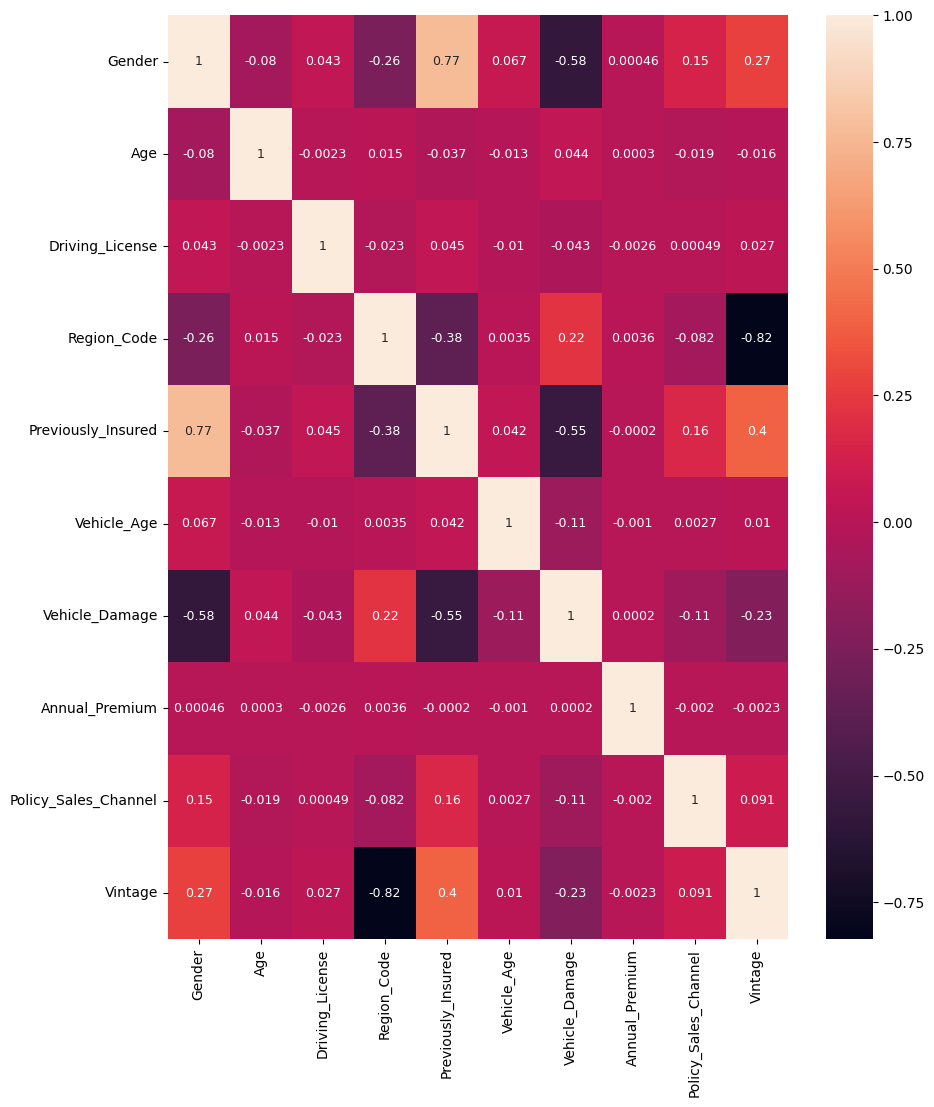

In [77]:
# Converti gli array NumPy in DataFrame
nomi_colonne_di_X = df_insurance.columns.tolist()
X_train = pd.DataFrame(X_train, columns=nomi_colonne_di_X_senza_target)

# Cerchiamo le variabili + significative per addestrare il modello
plt.figure(figsize=(10,12))
sns.heatmap(X_train.corr(), annot=True, annot_kws={"size":9})

# dalla matrice vediamo che le variabili maggiormente correlate con la variabile target (tra 1 e -1) sono :
# il meno correlato è Previusly insured (-0.0011) (+ correlato negativamente)
# il valore più correlato in termini di magnitudine è 0.35 (Vehicle_Damage) (+ correlato positivamente)

## VERIFICO SBILANCIAMENTO

0    0.877733
1    0.122267
Name: Response, dtype: float64


<Axes: title={'center': 'Distribuzione delle classi'}>

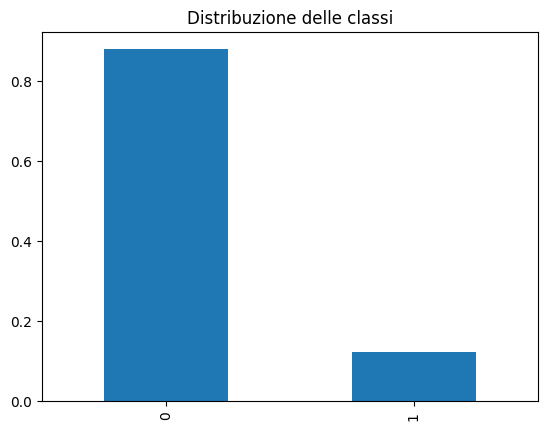

In [78]:
# Verifica lo sbilanciamento del set di dati
conteggio_classi = y_train.value_counts(normalize=True)
print(conteggio_classi)

# Grafico delle distribuzioni delle classi
conteggio_classi.plot(kind='bar', title='Distribuzione delle classi')

Dal grafico e dalle statistiche vediamo che la variabile target "Response" è sbilanciata, pertanto è necessario fare un bilanciamento.

## CORREGGO SBILANCIAMENTO CON OVERSAMPLING


L'oversampling (o qualsiasi tecnica di gestione degli sbilanciamenti) dovrebbe essere applicato solo all'insieme di addestramento (training set) e non all'insieme di test. Questo perché l'insieme di test deve rimanere rappresentativo della distribuzione reale dei dati che incontrerà in un ambiente di produzione o in situazioni del mondo reale.

1    234158
0    234158
Name: Response, dtype: int64


<Axes: title={'center': 'Distribuzione delle classi'}>

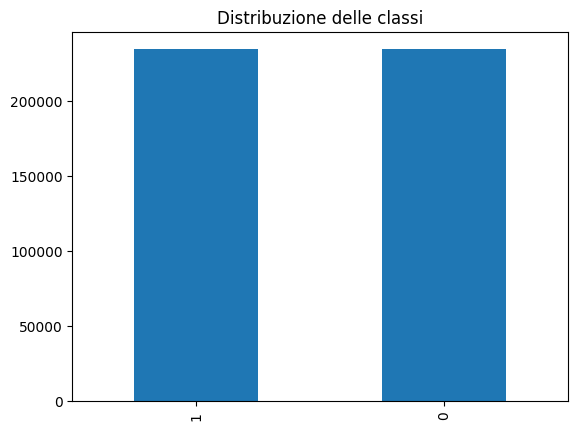

In [79]:
#X = df_insurance.drop('Response', axis=1)
#y = df_insurance['Response']

# Applica SMOTE per oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Crea un nuovo DataFrame con le features e il target resampled
df_resampled = pd.concat([X_train, y_train], axis=1)

# Conta le classi dopo l'oversampling
conteggio_classi = df_resampled['Response'].value_counts()
print(conteggio_classi)
conteggio_classi.plot(kind='bar', title='Distribuzione delle classi')

#MODELLO di CLASSIFICAZIONE BINARIA usando la REGRESSIONE LOGISTICA

• **Response** = variabile **TARGET** (variabile dipendente)

• le altre sono **FEATURE** (variabili indipendenti)

La CLASSIFICAZIONE BINARIA è un task dell'apprendimento supervisionato, in cui l'oggetto della previsione è una variabile CATEGORICA ("Response" che può assumere solo 2 categorie: 0 o 1).

Utilizzo quindi la REGRESSIONE LOGISTICA (che è un modello della classificazione binaria)


Dato che la variabile target ha solo due categorie, ma abbiamo più variabili indipendenti per effettuare la previsione, allora possiamo utilizzare la REGRESSIONE LOGISTICA per ottenere la probabilità di appartenenza a una delle due categoria.





In [80]:
# creiamo modello

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(random_state=42) # Creazione del modello di regressione logistica
model.fit(X_train, y_train) # Addestramento del modello sul set di train


LogisticRegression(random_state=42)

VALUTIAMO IL MODELLO

In [81]:
# MATRICE DI CONFUSIONE (si applica sulle classi)

def plot_confusion_matrix(y_true, y_pred, labels=["Negative", "Positive"], show_precision=True, show_recall=True):

  cm = confusion_matrix(y_true, y_pred) # tn, fp, fn, tp

  df_cm = pd.DataFrame(cm, index = labels,
                    columns = ["Predicted "+labels[0],"Predicted "+labels[1]])
  sns.heatmap(df_cm, annot=True)

PREVISIONE SET DI TRAIN

TRAIN LOSS: 0.4419523803882285
TRAIN REPORT
Classification Report TRAIN:
               precision    recall  f1-score   support

           0       0.96      0.59      0.73    234158
           1       0.71      0.98      0.82    234158

    accuracy                           0.78    468316
   macro avg       0.83      0.78      0.78    468316
weighted avg       0.83      0.78      0.78    468316

Confusion Matrix TRAIN:
 [[138796  95362]
 [  5770 228388]]


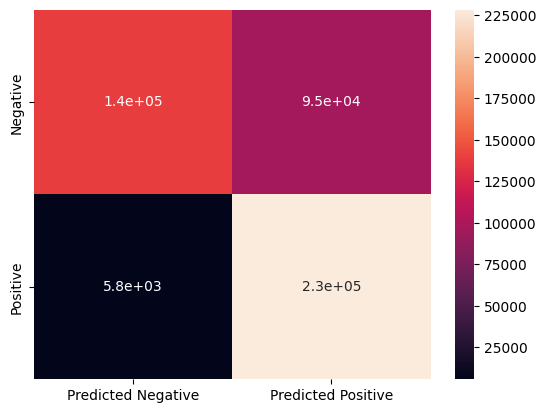

In [82]:
# eseguiamo la previsione
y_pred_train = model.predict(X_train)
y_proba_train = model.predict_proba(X_train)

# LOG LOSS (si applica sulle probabilità)
print(f"TRAIN LOSS: {log_loss(y_train, y_proba_train)}")

# costruiamo i report
print("TRAIN REPORT")
print('Classification Report TRAIN:\n', classification_report(y_train, y_pred_train))
print('Confusion Matrix TRAIN:\n', confusion_matrix(y_train, y_pred_train))
plot_confusion_matrix(y_train, y_pred_train)

- TRAIN LOSS: Il valore della funzione di perdita sul set di addestramento è 0.442, indicando l'errore medio del modello durante l'addestramento.

- **Precision**: La precisione per la classe 0 è alta (96%), mentre per la classe 1 è del 71%. Questo suggerisce che il modello è bravo a identificare correttamente gli assicurati che non sono interessati, ma meno bravo a identificare quelli che sono interessati all'assicurazione veicoli.
- **Recall**: La recall per la classe 0 è del 59%, mentre per la classe 1 è del 98%. Ciò indica che il modello ha una buona capacità di catturare gli assicurati interessati, ma meno di catturare quelli non interessati.
- **F1-score**: L'F1-score, che bilancia precision e recall, è del 78%.
- **Accuracy**: L'accuratezza complessiva del modello sul set di addestramento è del 78%.

- **matrice di confusione** mostra il numero di previsioni corrette e errate fatte dal modello. Il modello sembra fare più errori nel prevedere la classe 0 rispetto alla classe 1, come evidenziato dai falsi positivi (95,362) rispetto ai falsi negativi (5,770).

CONCLUSIONE:
Il modello soffre di uno sbilanciamento nella capacità di prevedere le due classi.


PREVISIONE SET DI TEST

TEST REPORT
Classification Report TEST:
               precision    recall  f1-score   support

           0       0.99      0.59      0.74    100241
           1       0.25      0.98      0.40     14092

    accuracy                           0.64    114333
   macro avg       0.62      0.78      0.57    114333
weighted avg       0.90      0.64      0.70    114333

Confusion Matrix TEST:
 [[59287 40954]
 [  333 13759]]


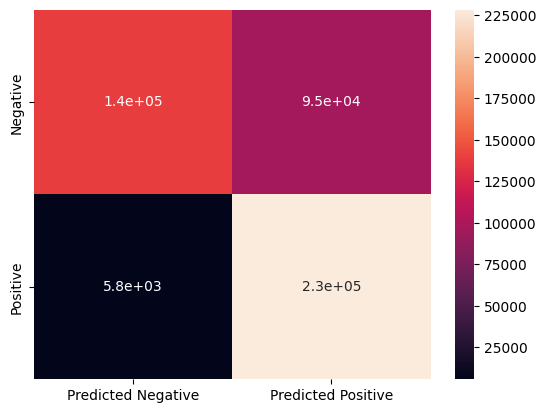

In [83]:
X_test = pd.DataFrame(X_test, columns=X_train.columns)
#print("Nomi delle colonne in X_train:", X_train.columns)
#print("Nomi delle colonne in X_test:", X_test.columns)

y_pred_test = model.predict(X_test)
y_proba_test = model.predict_proba(X_test)

#print(f"TRAIN LOSS: {log_loss(y_test, y_proba_test)}")

print("TEST REPORT")
print('Classification Report TEST:\n', classification_report(y_test, y_pred_test))

print('Confusion Matrix TEST:\n', confusion_matrix(y_test, y_pred_test))
plot_confusion_matrix(y_train, y_pred_train)

precision e recall sono notevolmente peggiorate sul set di test.

Considerazioni:

- LOG LOSS (funzione di costo) migliore sul set di train (valore minore)
- accuracy: del 78% sul set di train, mentre del 64% per il set di test

- MATRICE DI CONFUSIONE:
  - TRAIN TEST:
  la classe 1 mostra risultati molto positivi sia in termini di precision che di recall. Questo suggerisce che il modello è capace di identificare e classificare correttamente i casi positivi.
  La classe 0 mostra una precision molto alta, ma la recall è significativamente più bassa. Questo indica che, sebbene il modello sia molto sicuro quando predice uno 0, molti veri 0 non vengono identificati correttamente (molti falsi negativi).


  - TEST SET: la precision (=classificazioni positive effettivamente positive) della classe 1 è significativamente peggiorata sul test set.


quindi andiamo a migliorare la precision sul set di test andando ad applicare il bilanciamento anche sul set di test


0    100241
1    100241
Name: Response, dtype: int64


<Axes: title={'center': 'Distribuzione delle classi'}>

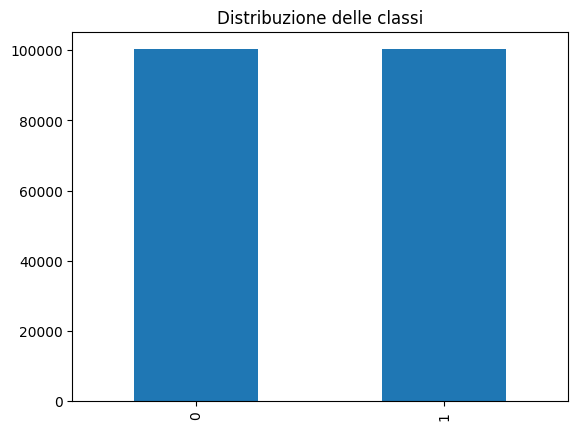

In [84]:
#X = df_insurance.drop('Response', axis=1)
#y = df_insurance['Response']

# Applica SMOTE per oversampling
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_test, y_test = smote.fit_resample(X_test, y_test)

# Crea un nuovo DataFrame con le features e il target resampled
df_resampled_test = pd.concat([X_test, y_test], axis=1)

# Conta le classi dopo l'oversampling
conteggio_classi_test = df_resampled_test['Response'].value_counts()
print(conteggio_classi_test)
conteggio_classi_test.plot(kind='bar', title='Distribuzione delle classi')

# ricalcolo la prevsione sul set di test


TRAIN LOSS: 0.43952789490435673
TEST REPORT
Classification Report TEST:
               precision    recall  f1-score   support

           0       0.96      0.59      0.73    100241
           1       0.71      0.98      0.82    100241

    accuracy                           0.78    200482
   macro avg       0.84      0.78      0.78    200482
weighted avg       0.84      0.78      0.78    200482

Confusion Matrix TEST:
 [[59287 40954]
 [ 2172 98069]]


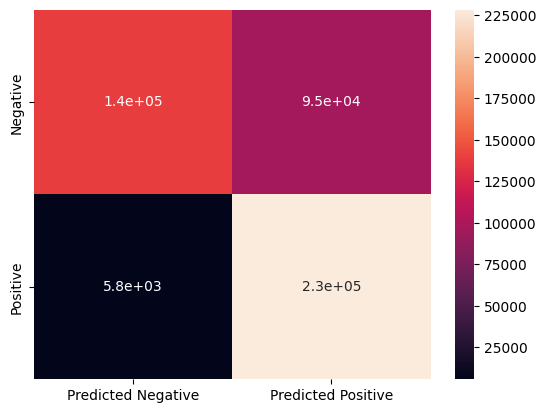

In [85]:
X_test = pd.DataFrame(X_test, columns=X_train.columns)

y_pred_test = model.predict(X_test)
y_proba_test = model.predict_proba(X_test)

print(f"TRAIN LOSS: {log_loss(y_test, y_proba_test)}")

print("TEST REPORT")
print('Classification Report TEST:\n', classification_report(y_test, y_pred_test))

print('Confusion Matrix TEST:\n', confusion_matrix(y_test, y_pred_test))
plot_confusion_matrix(y_train, y_pred_train)

ancche in questo caso l'accuracy è milgiorata e la ma™rice di confusione identifica bene i casi preedti come positivi che poi sono effettivamente positivi.

Visto che l'obiettivo principale è quello di individuare il valore della variabile response, mi interessa principalmente la capacità del modello di individuare correttamente i veri positivi (quelli che hanno effettivamente risposto positivamente).